In [1]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re
import os.path
import os

interesting_keys = ['episode_reward_mean', "episode_len_mean", 'episodes_total', 'custom_metrics/inv', "time_this_iter_s", 'custom_metrics/accept']
hist_keys = ["inv", "accept"]


def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 0}
    
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    events = ea.Scalars("ray/tune/episode_reward_mean")
    ids = [x.step for x in events]
    ids_s = set(x.step for x in events)
    df['step'] = ids
    walltimes = [x.wall_time for x in events]
    df['walltime'] = walltimes
    df['totalwalltime'] = walltimes[-1] - walltimes[0]
    df.set_index('step', inplace=True)
    for tag in hist_keys:
        fulltag = 'ray/tune/hist_stats/' + tag
        events = ea.Histograms(fulltag)
        indexes = [x.step for x in events if x.step in ids_s]
        mins = [x.histogram_value.min
                for x in events if x.step in ids_s]
        maxs = [x.histogram_value.max 
                for x in events if x.step in ids_s]
        means = [x.histogram_value.sum / x.histogram_value.num 
                 for x in events if x.step in ids_s]
        variances = [np.max((0, x.histogram_value.sum_squares / x.histogram_value.num - (x.histogram_value.sum / x.histogram_value.num)**2))
                     for x, mean in zip(events, means) if x.step in ids_s]
        stds = np.sqrt(variances)
        #print(events[-1].histogram_value)
        df.loc[indexes, tag+"_max"] = maxs
        df.loc[indexes, tag+"_min"] = mins
        df.loc[indexes, tag+"_mean"] = means
        df.loc[indexes, tag+"_std"] = stds
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        success = False
        for i in range(3):
            try:
                events = ea.Scalars(fultag)
            except KeyError:
                fultag+= "_mean"
            else:
                success = True
                break
        if not success:
            raise KeyError(fultag)

        scalars = np.array([x.value for x in events if x.step in ids_s])
        indexes = np.array([x.step for x in events if x.step in ids_s])
        df.loc[indexes, tag] = scalars

    df.reset_index(inplace=True)
    return df


def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

In [2]:
nepisodes=200000
mainpath = f'logs/paperrun2/e200000/ppobiglr//**/*tfevents*'
mainpath = f'logs/paperrun3/bignetfastredo//**/*tfevents*'
mainpath = "bench/logs/e200000/cmafixed/**/*tfevents*"
mainpath = "logs/paperrun3/lr_schedule/**/*tfevents*"
#mainpath = "bench/logs/logs/paperrun3/timebenchdeep/**/*tfevents*"


first, _ = mainpath.split("**")

shortname = ''.join(removeprefix(first, 'logs/').split('/'))
print(shortname)

figdir = "figures/" + shortname + "/"
os.makedirs(figdir, exist_ok=True)

paperrun3lr_schedule


In [3]:
fuldfs = []
runid = 0
forcereload = True

if not forcereload and os.path.exists(first + "/sumup.df.pkl"):
    alldf = pd.read_pickle(first + "/sumup.df.pkl")
else:
    for path in tqdm.tqdm(glob(mainpath, recursive=True)):
        try:
            curdf = create_df(path)
        except Exception as e:
            print(path)
            print(type(e), e)
        else:
            curdf['run'] = runid
            curdf['badsiteprob'] = float(re.search("good_site_prob=(.+?),", path).group(1))
            curdf['trial_id'] = re.search(r"partner_choice_(.+)_(?:\d+)_good", path).group(1)
            try:
                curdf['lr'] = re.search(r"lr=([-0-9.e+]+)_", path).group(1)
            except:
                pass
            fuldfs.append(curdf)
            runid += 1
    alldf = pd.concat(fuldfs)
    first, _ = mainpath.split("**")
    binsize = 1000
    mode = "ppo"
    if "cma" in mainpath: 
        mode = "cma"
    else:
        mode = "ppo"
    ps = [1, 0.5, 0.2, 0.1]
    if "true_episode_reward_mean" not in alldf.columns:
        alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
    if mode == "ppo": 
        alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
    if "p" not in alldf.columns:
        alldf["p"] = alldf["badsiteprob"]

    alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
    alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
    alldfful = alldf
    alldf = alldf.query("p in @ps").copy()
    alldf.to_pickle(first + "/sumup.df.pkl")

100%|██████████| 69/69 [10:39<00:00,  9.27s/it]


In [4]:
figwidth = 3.3

In [5]:
binsize = nepisodes//200
stepbin = alldf["step"].max() // 300
print(binsize)
print(stepbin)

if "cma" in mainpath: 
    mode = "cma"
else:
    mode = "ppo"
ps = [1, 0.5, 0.2, 0.1]
alldf = alldf.query("p in @ps").copy()

if "true_episode_reward_mean" not in alldf.columns:
    alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
if mode == "ppo": 
    alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
if "p" not in alldf.columns:
    alldf["p"] = alldf["badsiteprob"]


alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )

alldf["episode_bin_right"].where(alldf["episode_bin_right"] <= nepisodes, nepisodes, inplace=True)

alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
alldf = alldf.query("p in @ps").copy()


1000
101392


In [6]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figsize=(figwidth, figwidth/1.5)

In [7]:
alldf.query("p == 1").groupby("run").max()

,step,walltime,totalwalltime,inv_max,inv_min,inv_mean,inv_std,accept_max,accept_min,accept_mean,...,episodes_total,custom_metrics/inv,time_this_iter_s,custom_metrics/accept,badsiteprob,trial_id,true_episode_reward_mean,p,episode_bin_right,step_bin_right
run,,,,,,,,,,,,,,,,,,,,,
0,4161600,1.612179e+09,5504.266442,15.0,9.701671,9.746827,3.691763,15.0,8.5,9.109890,...,200098.0,9.746902,8.386869,9.109890,1.0,c3f37_00000,93.816170,1.0,200000.0,4162000
1,4416000,1.612185e+09,5970.937646,15.0,9.702738,9.807722,5.169248,15.0,8.5,10.326316,...,200199.0,9.817795,7.930578,10.326316,1.0,c3f37_00003,95.363747,1.0,200000.0,4417000
2,9825600,1.612201e+09,15960.531789,15.0,10.071456,10.403111,5.427691,15.0,10.0,10.474490,...,200058.0,10.397038,8.847544,10.474490,1.0,c3f37_00004,99.674049,1.0,200000.0,9826000
3,9388800,1.612188e+09,13713.072780,15.0,9.770379,10.460036,4.443078,15.0,9.5,10.237374,...,200038.0,10.483752,8.556230,10.237373,1.0,c3f37_00002,98.339417,1.0,200000.0,9389000
4,10344000,1.612219e+09,17602.180007,15.0,10.809469,10.945979,4.498596,15.0,10.5,10.676768,...,200127.0,10.956150,8.472929,10.676767,1.0,c3f37_00008,98.335938,1.0,200000.0,10345000
5,4200000,1.612209e+09,6904.255824,15.0,10.170877,10.401612,4.215456,15.0,9.0,9.789855,...,200224.0,10.401108,7.876906,9.789855,1.0,c3f37_00009,94.642372,1.0,200000.0,4201000
6,4118400,1.612206e+09,6509.301213,15.0,10.585332,10.731600,4.596018,15.0,10.0,10.268293,...,200164.0,10.729797,8.004483,10.268292,1.0,c3f37_00007,96.388512,1.0,200000.0,4119000
7,7742400,1.612199e+09,11484.686295,15.0,10.626138,10.806141,4.274651,15.0,10.5,10.500000,...,200033.0,10.802922,8.723640,10.500000,1.0,c3f37_00006,98.867271,1.0,200000.0,7743000
8,3331200,1.612263e+09,10593.282424,15.0,9.813615,10.603933,5.348220,15.0,9.0,10.365854,...,150567.0,10.594423,8.308377,10.365853,1.0,c3f37_00018,94.171959,1.0,151000.0,3332000


In [8]:
from pandas.api.types import CategoricalDtype
ps = [1, 0.5, 0.2, 0.1]
step = False
epcollapsed = alldf.groupby(["trial_id", "episode_bin_right"], as_index=False).agg(
    {"episode_reward_mean": "mean",
     "p": "first",
     "custom_metrics/inv": "mean",
     "custom_metrics/accept": "mean"
     })
epcollapsed["epthousands"] = epcollapsed["episode_bin_right"] / 1000

print("ep done")
if step:
    stepcollapsed = alldf[["p", "run", "step_bin_right", "inv_mean", "inv_std", "accept_mean"]].groupby(["p", "run", "step_bin_right"], as_index=False).mean()
    stepcollapsed["p"] = stepcollapsed["p"].astype(pcat)

print("step done")
pcat = CategoricalDtype(ps, ordered=True)
epcollapsed["p"] = epcollapsed["p"].astype(pcat)
print("p as cat done")
alldf["p"] = alldf["p"].astype(pcat)

ep done
step done
p as cat done


In [9]:
epcollapsed

,trial_id,episode_bin_right,episode_reward_mean,p,custom_metrics/inv,custom_metrics/accept,epthousands
0,c382d_00000,1000.0,11.914032,0.5,0.752866,0.146935,1.0
1,c382d_00000,2000.0,19.028711,0.5,1.621793,0.381761,2.0
2,c382d_00000,3000.0,25.219338,0.5,2.296674,0.606437,3.0
3,c382d_00000,4000.0,30.572141,0.5,2.959723,0.920044,4.0
4,c382d_00000,5000.0,32.825285,0.5,3.541442,1.109000,5.0
...,...,...,...,...,...,...,...
12739,ccffc_00008,64000.0,38.313677,0.1,8.591360,6.452857,64.0
12740,ccffc_00008,65000.0,38.277860,0.1,8.586522,6.441429,65.0
12741,ccffc_00008,66000.0,38.367752,0.1,8.587811,6.461000,66.0
12742,ccffc_00008,67000.0,38.881520,0.1,8.588058,6.563929,67.0


In [10]:
epcollapsed.query("p == 1 and epthousands == 200").groupby("p")

In [11]:
epcollapsed.query("epthousands in [200]").groupby(["trial_id"]).agg({"p": "first", "episode_reward_mean": "mean"}).query("episode_reward_mean >= 40").groupby("p").count()

,episode_reward_mean
p,
0.1,1
0.2,13
0.5,21
1.0,14


In [12]:
print("ok")
try:
    print(epcollapsed.query("episode_bin_right >= 200000").groupby("p")["trial_id"].nunique())
except Exception as e:
    print(type(e), e)
    print("no run finished")

ok
p
1.0    16
0.5    21
0.2    14
0.1     6
Name: trial_id, dtype: int64


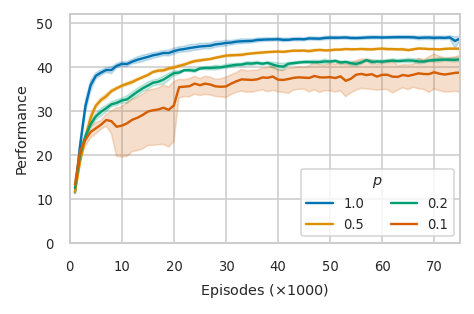

In [13]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
#sns.lineplot(
#    data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p",
#    estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
#)

sns.lineplot(data=epcollapsed, x="epthousands", y='episode_reward_mean', hue="p", ax=ax)

#ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.ylim(0, 52)
plt.xlim(0, 75)
plt.ylabel('Performance')
plt.xlabel('Episodes ($\\times 1000$)')
plt.legend(ncol=2, title="$p$")
plt.tight_layout()
plt.savefig(figdir + "reward_mean_synth.pdf")

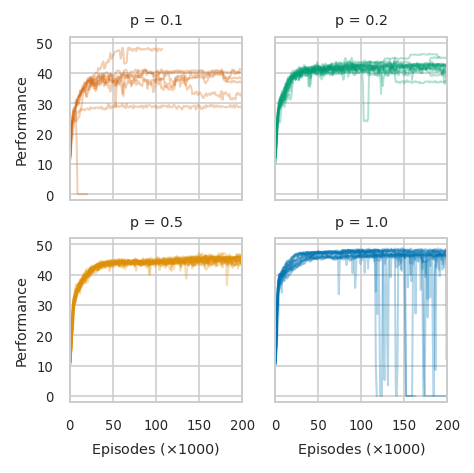

In [14]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/2), aspect=1, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_reward_mean',
        estimator=None, alpha=0.3, linewidth=1, units="trial_id")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
for ax in g.axes:
    #ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_yticks([i for i in range(0, 51, 10)])
    ax.set_ylim(-2, 52)
    ax.set_xlim(0, 200)
g.set_axis_labels("Episodes ($\\times 1000$)", "Performance")
g.tight_layout()
g.savefig(figdir + "reward_mean_detail.pdf")

,episode_reward_mean
p,
0.20,1
0.50,21
1.00,23


In [ ]:
for i, (name, group) in enumerate(epcollapsed.groupby("p")):
    fig = plt.figure(figsize=(figwidth/1.3, figwidth/2))
    ax = fig.gca()
    sns.lineplot(data=group, x="epthousands", y="episode_reward_mean", estimator=None, units="trial_id", alpha=0.3, linewidth=1, color=sns.color_palette()[i])
    #ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylabel("Performance")
    ax.set_xlabel("Episodes ($\\times 1000$)")
    ax.set_title(f"$p = {name}$")
    ax.set_ylim(-2, 52)
    ax.set_yticks([i for i in range(0, 51, 10)])
    fig.tight_layout()
    fig.savefig(figdir + f"reward_mean_detail_p{name}.pdf")
    plt.show(fig)

In [ ]:
if step:
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    sns.lineplot(
            data=stepcollapsed, x="step_bin_right", y='episode_reward_mean', hue="p",
            estimator=None, linewidth=1, ax=ax, units="run"
        )
    ax.ticklabel_format(axis="x", scilimits=(6, 6))

    plt.ylim(0, 50)
    plt.ylabel('Performance')
    plt.xlabel('# step')
    plt.legend(ncol=2, title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "reward_mean_synth_step.pdf")

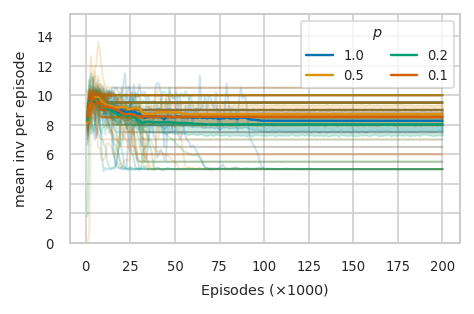

In [367]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="epthousands", y='custom_metrics/inv', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="trial_id", legend=False
    )

sns.lineplot(data=epcollapsed, x="epthousands", y='custom_metrics/inv', hue="p", ax=ax)

plt.ylim(0, 15.5)
plt.ylabel('mean inv per episode')
plt.xlabel('Episodes ($\\times 1000$)')
plt.legend(ncol=2, title="$p$")
#ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "inv_mean_synth.pdf")

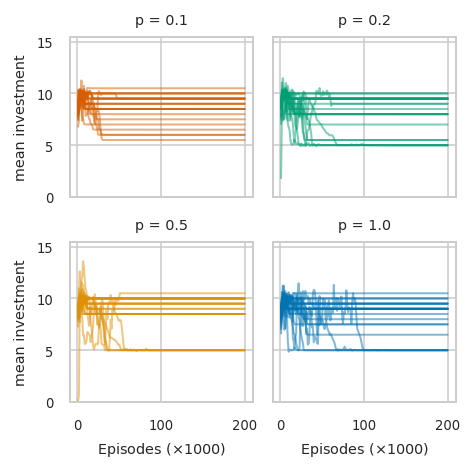

In [317]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/2, aspect=1, sharex=True, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="epthousands", y='custom_metrics/inv',
        estimator=None, alpha=0.5, linewidth=1, units="trial_id")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv')
for ax in g.axes:
    #ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylim(0, 15.5)
g.set_axis_labels("Episodes ($\\times 1000$)", "mean investment")
g.tight_layout()
g.savefig(figdir + "inv_mean_details.pdf")

In [318]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/inv', hue="p", units="trial_id", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean inv per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "inv_mean_synth_step.pdf")

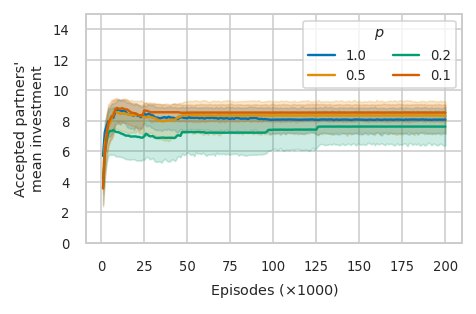

In [319]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
#sns.lineplot(
#        data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p",
#        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
#    )

sns.lineplot(data=epcollapsed, x="epthousands", y='custom_metrics/accept', hue="p", ax=ax)


plt.ylim(0, 15)
plt.ylabel('Accepted partners\'\nmean investment')
plt.xlabel('Episodes ($\\times 1000$)')
plt.legend(title="$p$", ncol=2)
#ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "accept_mean_synth.pdf")

In [320]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/accept', hue="p", units="trial_id", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean accept per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "accept_mean_step.pdf")

ValueError: Could not interpret value `accept_mean` for parameter `y`

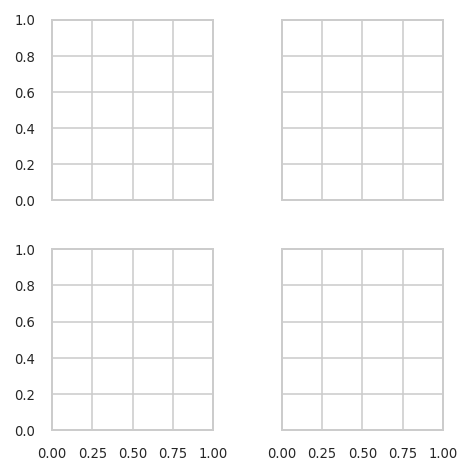

In [321]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="epthousands", y='accept_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="epthousands", y='accept_mean')
#for ax in g.axes:
#    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("Episodes ($\\times 1000$)", "Accepted partners'\nmean investment")
g.tight_layout()

plt.savefig(figdir + "accept_mean_detail.pdf")

In [ ]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="epthousands", y='accept_min',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="epthousands", y='accept_min')
#for ax in g.axes:
#    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("Episodes ($\\times 1000$)", "Accepted partners'\nminimum investment")

g.tight_layout()
plt.savefig(figdir + "accept_min_detail.pdf")

In [ ]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/(1*2)), aspect=1, sharey=False, hue="p",
                  despine=False, col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_len_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run", )
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_len_mean')
#for ax in g.axes:
#    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("Episodes ($\\times 1000$)", "Mean episode length")
g.tight_layout()

plt.savefig(figdir + "episode_mean_detail.pdf")

In [ ]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False,
                 col_order=[0.1, 0.2, 0.5, 1.0])
g.map_dataframe(sns.lineplot, x="epthousands", y='inv_std',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="epthousands", y='inv_std')
#for ax in g.axes:
#    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set(ylim=(-2, 2))
g.set_axis_labels("Episodes ($\\times 1000$)", "Investment std")
g.tight_layout()

plt.savefig(figdir + "inv_std_detail.pdf")

In [191]:
def compute_time(outalldf):
    outcmamax = outalldf.groupby(["p", "trial_id"]).apply(lambda x: x[x.walltime == x.walltime.max()][["walltime", "step"]]).droplevel(2)
    outcmamin = outalldf.groupby(["p", "trial_id"]).apply(lambda x: x[x.walltime == x.walltime.min()][["walltime", "step"]]).droplevel(2)
    outcma = outcmamax.join(outcmamin, rsuffix="_min", lsuffix="_max")
    outcma["totaltime"] = outcma["walltime_max"] - outcma["walltime_min"]
    outcma["totalstep"] = outcma["step_max"] - outcma["step_min"]
    outcma["time_per_step"] = outcma["totaltime"] / outcma["totalstep"] * 1000
    return outcma


outalldf = pd.read_pickle("bench/logs/logs/paperrun3/timebench/sumup.df.pkl")
outppo = compute_time(outalldf)


outalldf = pd.read_pickle("bench/logs/e200000/cmafixed/sumup.df.pkl")
outcma = compute_time(outalldf)


outalldf = pd.read_pickle("bench/logs/logs/paperrun3/timebenchdeep/sumup.df.pkl")
outppodeep = compute_time(outalldf)

In [192]:
outcma["Algorithm"] = "CMA-ES"
outppo["Algorithm"] = "PPO-MLP"
outppodeep["Algorithm"] = "PPO-DEEP"



outcomb = pd.concat((outcma, outppo, outppodeep))
outcomb = outcomb.reset_index()
alg_order = ["CMA-ES", "PPO-DEEP", "PPO-MLP"]

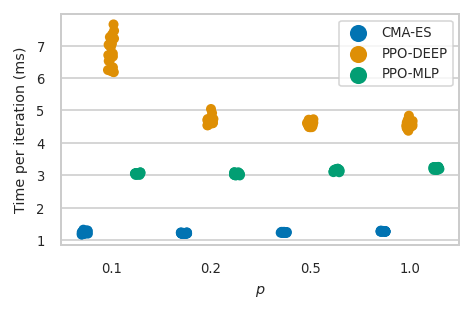

In [193]:
plt.figure(figsize=figsize)
sns.stripplot(data=outcomb, x="p", hue="Algorithm", y="time_per_step", hue_order=alg_order, dodge=True)
plt.ylabel("Time per iteration (ms)")
plt.xlabel("$p$")
plt.legend()
plt.tight_layout()
plt.savefig("figures/paperrun2e200000/time_per_it.pdf")

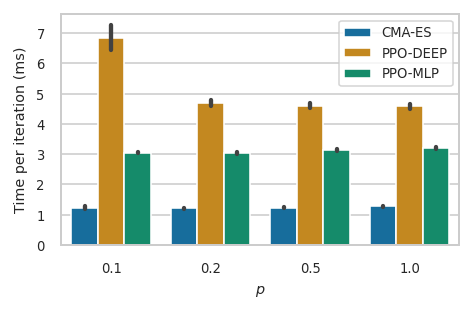

In [196]:
plt.figure(figsize=figsize)
sns.barplot(data=outcomb, x="p", hue="Algorithm", y="time_per_step", hue_order=alg_order, ci="sd")
plt.ylabel("Time per iteration (ms)")
plt.xlabel("$p$")
plt.legend()
plt.tight_layout()
plt.savefig("figures/paperrun2e200000/time_per_it.pdf")

In [172]:
outcomb.groupby(["Algorithm", "p"])[["time_per_step"]].agg(["mean", "std"]).style.format(
    {("time_per_step", "mean"): "{:2.2f}",
     ("time_per_step", "std"): "{:2.2f}"})


In [213]:
import itertools 
outdict = []
for alg1, alg2 in itertools.product(alg_order, repeat=2):
    talg1 = outcomb.query("Algorithm == @alg1")["time_per_step"].mean()
    talg2 = outcomb.query("Algorithm == @alg2")["time_per_step"].mean()
    outdict.append({"alg1": alg1, "alg2": alg2, "ratio": talg1 / talg2})
a = pd.DataFrame(outdict)
print(a.pivot_table(columns="alg1", index="alg2", values="ratio").to_latex())

\begin{tabular}{lrrr}
\toprule
alg1 &  CMA-ES &  PPO-DEEP &  PPO-MLP \\
alg2     &         &           &          \\
\midrule
CMA-ES   &    1.00 &      4.18 &     2.51 \\
PPO-DEEP &    0.24 &      1.00 &     0.60 \\
PPO-MLP  &    0.40 &      1.66 &     1.00 \\
\bottomrule
\end{tabular}



In [187]:
pd.options.display.float_format = '{:,.2f}'.format
print(outcomb.groupby(["Algorithm", "p"])[["time_per_step"]].agg(["mean", "std"]).to_latex())

outout = outcomb.groupby(["p", "Algorithm"])[["time_per_step"]].agg(["mean", "std"])

\begin{tabular}{llrr}
\toprule
        &      & \multicolumn{2}{l}{time\_per\_step} \\
        &      &          mean &  std \\
Algorithm & p &               &      \\
\midrule
CMA-ES & 0.10 &          1.24 & 0.04 \\
        & 0.20 &          1.21 & 0.01 \\
        & 0.50 &          1.24 & 0.01 \\
        & 1.00 &          1.27 & 0.01 \\
PPO-DEEP & 0.10 &          6.86 & 0.43 \\
        & 0.20 &          4.69 & 0.11 \\
        & 0.50 &          4.60 & 0.08 \\
        & 1.00 &          4.58 & 0.10 \\
PPO-MLP & 0.10 &          3.05 & 0.02 \\
        & 0.20 &          3.04 & 0.03 \\
        & 0.50 &          3.14 & 0.03 \\
        & 1.00 &          3.21 & 0.03 \\
\bottomrule
\end{tabular}



In [186]:
outout["Time per step (ms)"] = "$ " + outout[("time_per_step", "mean")].astype(str) + "\pm" + outout[("time_per_step", "std")].astype(str) + " $"

In [184]:
outout[["Time per step (ms)"]]

Time per step (ms)
                                                             
p    Algorithm                                               
0.10 CMA-ES      $ 1.2364487511835816\pm0.04100415438593147 $
     PPO-DEEP     $ 6.855595691894531\pm0.42620910280256086 $
     PPO-MLP    $ 3.0484567059747287\pm0.018595953206484665 $
0.20 CMA-ES      $ 1.211281251625413\pm0.013535754069254967 $
     PPO-DEEP     $ 4.692265275338207\pm0.10682394969392399 $
     PPO-MLP    $ 3.0443716872939675\pm0.029337995763465036 $
0.50 CMA-ES     $ 1.2373287953702163\pm0.009352806468342894 $
     PPO-DEEP     $ 4.602879832087951\pm0.07957159670336353 $
     PPO-MLP      $ 3.144065147420164\pm0.02842882268870003 $
1.00 CMA-ES     $ 1.2722322102946344\pm0.008923792832396553 $
     PPO-DEEP     $ 4.577770162759397\pm0.09852433509470428 $
     PPO-MLP     $ 3.2137379964868287\pm0.02904674077400497 $

In [133]:
outalldf = pd.read_pickle("logs/paperrun2/e200000/ppobiglr/sumup.df.pkl")
out = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])
outalldf = pd.read_pickle("logs/paperrun2/e200000/cmafixed/sumup.df.pkl")
outcma = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])
outcma["Algorithm"] = "CMA-ES"

out["Algorithm"] = "PPO-MLP"
out["timeperit"] = out["totalwalltime"] / out["step"] * 1000
outcma["timeperit"] = outcma["totalwalltime"] / outcma["step"] * 1000
outcomb = pd.concat((outcma, out))
outcomb["totalwalltimehour"] = outcomb["totalwalltime"] / (60*60)


In [134]:
outcomb.groupby(["p", "Algorithm"])[["totalwalltimehour", "timeperit"]].agg(["mean", "std"]).style.format(
    {("totalwalltimehour", "mean"): "{:2.2f}",
     ("totalwalltimehour", "std"): "{:2.2f}",
    ("timeperit", "mean"): "{:2.2f}",
    ("timeperit", "std"): "{:2.2f}",})